# US Crime Communities 
### EDA & Hypothesis Testing

This is a dataset of 2018 US communities, demographics of each community, and their crime rates. The dataset has 146 variables where the first four columns are community/location, the middle features are demographic information about each community such as population, age, race, income, and the final columns are types of crimes and overall crime rates.

Table of Contents

### Mission Statement

The aim of this project is to analyse a comprehensive dataset of US communities, gathered in 2018, in order to determine what factors contribute to high crime rates. This is a selective analysis in that only columns related to the selected target features for the analysis will be used. This is predominantly a project that will use the principles of Exploratory Data Analysis (EDA) and Hypothesis Testing to see what factors may or may not contribute to greater crime rates in a community.

### Data Understanding

Read in the data

In [55]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import math

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import norm
from scipy import stats

In [3]:
data = pd.read_csv('crimedata.csv')

In [4]:
data.head(3)

,communityName,state,countyCode,communityCode,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,5320.0,11980,3.10,1.37,91.78,6.50,1.88,...,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45.0,47616.0,23123,2.82,0.80,95.57,3.44,0.85,...,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,29344,2.43,0.74,94.33,3.43,2.35,...,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51


In [5]:
data.shape

(2215, 146)

Since we have 146 columns, we can perform a process of removing columns by inspection of quality and suitability for the analysis.

### Missing Values

In [6]:
missing_vols = pd.DataFrame(data.isnull().sum().sort_values(ascending=False))
missing_vols.reset_index(inplace=True)

In [7]:
missing_vols.head()

,index,0
0,PctPolicBlack,1872
1,PolicAveOTWorked,1872
2,PolicOperBudg,1872
3,LemasPctPolicOnPatr,1872
4,LemasGangUnitDeploy,1872


In [8]:
missing_vols.rename(columns={'index':'feature', 0:'total_missing'}, inplace=True)

In [9]:
missing_vols.describe()

,total_missing
count,146.000000
mean,305.424658
std,677.865329
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,1872.000000


In [10]:
# drop columns with 1872 missing
pd.set_option("display.max_columns", 200)
drop_list = missing_vols[missing_vols['total_missing'] == 1872]['feature'].unique().tolist()
data.drop([i for i in drop_list], axis=1, inplace=True)
data.shape

(2215, 124)

In [11]:

# inspect others above mean
mean_missing = missing_vols['total_missing'].mean()
missing_vols[(missing_vols.total_missing > mean_missing) & (missing_vols.total_missing != 1872)]
data.drop(columns=["communityCode", "countyCode"],inplace=True)

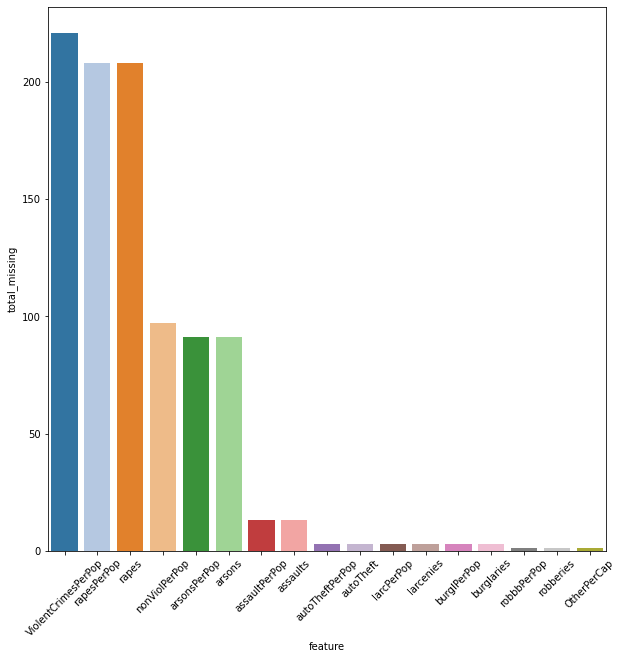

In [12]:
missing_vols = pd.DataFrame(data.isnull().sum().sort_values(ascending=False))
missing_vols.reset_index(inplace=True)
missing_vols.rename(columns={'index':'feature', 0:'total_missing'}, inplace=True)

# Visualise the missing data volumes for the remaining columns
fig, ax = plt.subplots(figsize=(10,10))
plot = sns.barplot(data=missing_vols[missing_vols['total_missing'] != 0],
                    x='feature', y="total_missing", ax=ax, palette='tab20')
plot.set_xticklabels(labels=plot.get_xticklabels(),rotation=45)
plt.show()

We have some remaining null values in the crime type columns. However before we decide on the most appropriate treatment, for them, we will drop the crime detail columns that have just the total number. For this analysis, it is more useful to utilise the columns that have the crime detail "Per Population" (per 100K of the town's overall population). This will be more useful when we begin to compare attributes.

In [13]:
pd.set_option("display.max_seq_items", 500)
data.columns[::-1]

Index(['nonViolPerPop', 'ViolentCrimesPerPop', 'arsonsPerPop', 'arsons',
       'autoTheftPerPop', 'autoTheft', 'larcPerPop', 'larcenies',
       'burglPerPop', 'burglaries', 'assaultPerPop', 'assaults', 'robbbPerPop',
       'robberies', 'rapesPerPop', 'rapes', 'murdPerPop', 'murders',
       'LemasPctOfficDrugUn', 'PctUsePubTrans', 'PopDens', 'LandArea',
       'PctSameState85', 'PctSameCity85', 'PctSameHouse85', 'PctBornSameState',
       'PctForeignBorn', 'NumStreet', 'NumInShelters', 'MedOwnCostPctIncNoMtg',
       'MedOwnCostPctInc', 'MedRentPctHousInc', 'MedRent', 'RentQrange',
       'RentHighQ', 'RentMedian', 'RentLowQ', 'OwnOccQrange', 'OwnOccHiQuart',
       'OwnOccMedVal', 'OwnOccLowQuart', 'PctWOFullPlumb', 'PctHousNoPhone',
       'MedYrHousBuilt', 'PctVacMore6Mos', 'PctVacantBoarded', 'PctHousOwnOcc',
       'PctHousOccup', 'HousVacant', 'MedNumBR', 'PctHousLess3BR',
       'PctPersDenseHous', 'PctPersOwnOccup', 'PersPerRentOccHous',
       'PersPerOwnOccHous', 'PersPerO

We can also see that there are specific attributes of the city, such as the number of people born in the same state, that are not going to be included in this analysis. These columns will also be dropped.

In [14]:
#'NumKidsBornNeverMar', 'PctKids2Par', 'medFamInc', 'pctWWage', 'PolicCars', 'PctWorkMomYoungKids','PctImmigRec10','FemalePctDiv','MalePctDivorce'

In [15]:
# cols_to_drop = ['arsons','autoTheft','larcenies','burgalries','assaults','robberies','rapes','murders',
#                 'PctBornSameState','PctSameHouse85','PctNotSpeakEnglWell', 'PctSpeakEnglOnly','PctRecImmig10',
#                 'PctRecImmig8','PctRecentImmig','PctImmigRec8',
#                 'PctImmigRecent','PctTeen2Par','PctYoungKids2Par',' MedNumBR','HousVacant','PctVacantBoarded',
#                 'PctVacMore6Mos','MedYrHousBuilt','PctHousNoPhone','PctWOFullPlumb','OwnOccLowQuart','OwnOccMedVal',
#                 'OwnOccHiQuart','RentLowQ','RentMedian','RentHighQ','MedRent','MedOwnCostPctInc','MedOwnCostPctIncNoMtg',
#                 'LemasSwornFT','LemasSwFTFieldOps','LemasSwFTFieldPerPop','LemasTotalReq','LemasSwFTFieldPerPop',
#                 'NumKindsDrugsSeiz',
#                 'LemasGangUnitDeploy','OfficAssgnDrugUnits','numbUrban', 'pctWFarmSelf',
#                 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'NumUnderPov', 'PctLess9thGrade',
#                 'PctEmplManu', 'PctOccupManu', 'PctEmplProfServ','OtherPerCap']
# len(cols_to_drop)
#data.drop

Target categories for the analysis:
* Police presence in the community
* Homelessness rates
* Household income
* Level of Education
* Family unit structure
* Race prevalence
* Proportion of immigrants
* Employment/Unemployment

In [16]:
# current_cols = data.columns.tolist()

# for col in cols_to_drop:
#     if col in current_cols:
#         data.drop(columns=col, inplace=True)

In [17]:
data.shape

(2215, 122)

In [18]:
pd.set_option("display.max_seq_items", 100)
data.columns

Index(['communityName', 'state', 'population', 'householdsize', 'racepctblack',
       'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21',
       'agePct12t29',
       ...
       'burglaries', 'burglPerPop', 'larcenies', 'larcPerPop', 'autoTheft',
       'autoTheftPerPop', 'arsons', 'arsonsPerPop', 'ViolentCrimesPerPop',
       'nonViolPerPop'],
      dtype='object', length=122)

We are probably only interested in the proportion of violent and non-violent crimes per 100k population. We don't need much more crime detail than that so we wil delete crime detail columns. 

In [19]:
cd_cols_to_drop = ['arsons','autoTheft','larcenies','burglaries','assaults','robberies','rapes','murders',
                   'murdPerPop', 'rapesPerPop', 'robbbPerPop', 'assaultPerPop',
                   'burglPerPop', 'larcPerPop', 'autoTheftPerPop','arsonsPerPop','OtherPerCap']
data.drop(columns=cd_cols_to_drop, inplace=True)
data.shape

(2215, 105)

Now we've selected our potential columns of interest, let's return to dealing with the remaining missing values in our selected features.

In [20]:
data.isnull().sum().sort_values(ascending=False)

ViolentCrimesPerPop    221
nonViolPerPop           97
PersPerOwnOccHous        0
PctVacMore6Mos           0
PctVacantBoarded         0
                      ... 
PctBSorMore              0
PctNotHSGrad             0
PctLess9thGrade          0
PctPopUnderPov           0
NumImmig                 0
Length: 105, dtype: int64

Unfortunately, the two remaining variables with missing values are our predicter variables. Let's assess the distribution of these columns using a uni-variate analysis before we decide what to do with the missing values.

<AxesSubplot:xlabel='ViolentCrimesPerPop'>

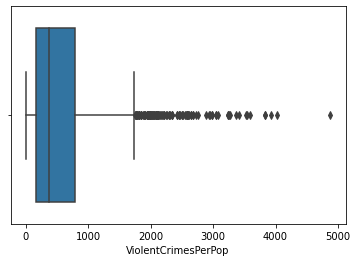

In [21]:
sns.boxplot(data=data, x='ViolentCrimesPerPop')

<AxesSubplot:xlabel='nonViolPerPop'>

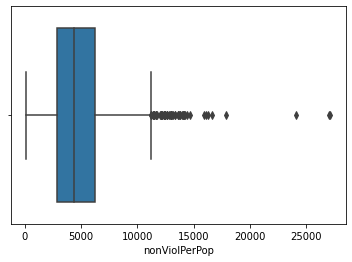

In [22]:
sns.boxplot(data=data, x='nonViolPerPop')

As we can see from both of these plts, we have some data points that are plotted outside of the box plot area and that greatly deviate from the rest of the population. As we're essentially trying to understand what drives violent and non violent crime in communities, these outlier numbers may provide us with insight later on. Nevertheless lets replace the missing values with the median since our data appears to be widely distributed.

In [23]:
nonViol_mean = np.mean(data.nonViolPerPop)
nonViol_median = data.nonViolPerPop.median()

viol_mean = np.mean(data.ViolentCrimesPerPop)
viol_median = data.ViolentCrimesPerPop.median()

print(f"Non Violent Crimes mean: {nonViol_mean}")
print(f"Non Violent Crimes median: {nonViol_median}")
print(f"Violent Crimes mean: {viol_mean}")
print(f"Violent Crimes median: {viol_median}")

Non Violent Crimes mean: 4908.241803588291
Non Violent Crimes median: 4425.450000000001
Violent Crimes mean: 589.0789217652964
Violent Crimes median: 374.06


In [24]:
data.nonViolPerPop.fillna(nonViol_median, inplace=True)
data.ViolentCrimesPerPop.fillna(viol_median, inplace=True)
print(f"Number of missing values in dataset: {data.isnull().sum().sum()}")

Number of missing values in dataset: 0


### Checking for Duplicates

There should only be one record per community and state combination. Let's check there are no duplicate records for this.

In [25]:
data[data[['communityName', 'state']].duplicated()]

,communityName,state,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumKidsBornNeverMar,PctKidsBornNeverMar,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop,nonViolPerPop


### Correlation Assessment

Before we proceed with any data cleaning of our new dataset, it is useful to establish a correlation between the response variables (in our case the non violent and violent crime rates per 100K population) and other predictor variables, as some of them might not have any major impact in determining the rate of crime and will not be used in the analysis. Below, we will use the `corr()` function to list the top features based on the pearson correlation coefficient, which measures how closely two sets of numbers are correlated.

In [26]:
crime_nums = data.select_dtypes(include=['float64','int64'])
viol_crime_nums_corr = crime_nums.corr()['ViolentCrimesPerPop']
top_features_viol = viol_crime_nums_corr[(abs(viol_crime_nums_corr) > 0.5) & (viol_crime_nums_corr != 1)].sort_values(ascending=False)
print(f"There are {len(top_features_viol)} features strongly correlated with the Violent Crime rate: \n{top_features_viol}")

There are 12 features strongly correlated with the Violent Crime rate: 
PctKidsBornNeverMar    0.686665
nonViolPerPop          0.627124
racepctblack           0.590580
FemalePctDiv           0.513018
TotalPctDiv            0.511019
pctWPubAsst            0.507611
pctWInvInc            -0.534563
PctYoungKids2Par      -0.611884
PctTeen2Par           -0.616963
racePctWhite          -0.647164
PctFam2Par            -0.649762
PctKids2Par           -0.684059
Name: ViolentCrimesPerPop, dtype: float64


In [27]:
nonviol_crime_nums_corr = crime_nums.corr()['nonViolPerPop']
top_features_nonviol = nonviol_crime_nums_corr[(abs(nonviol_crime_nums_corr) > 0.5) & (nonviol_crime_nums_corr != 1)].sort_values(ascending=False)
print(f"There are {len(top_features_nonviol)} features strongly correlated with the Non Violent Crime rate: \n{top_features_nonviol}")

There are 10 features strongly correlated with the Non Violent Crime rate: 
ViolentCrimesPerPop    0.627124
TotalPctDiv            0.596741
FemalePctDiv           0.589553
MalePctDivorce         0.576979
PctKidsBornNeverMar    0.543926
PctPopUnderPov         0.503480
PctYoungKids2Par      -0.598805
PctTeen2Par           -0.608651
PctFam2Par            -0.645484
PctKids2Par           -0.653018
Name: nonViolPerPop, dtype: float64


Let's visualise these relationships using pairplots. We can also then use the pairplots to identify any potential outliers.

In [28]:
top_features_viol_cols = pd.DataFrame(top_features_viol).transpose().columns.tolist()
top_features_viol_cols.append('ViolentCrimesPerPop')
top_features_viol_df = data.loc[:, [i for i in top_features_viol_cols]]

In [29]:
top_features_viol_df.head(3)

,PctKidsBornNeverMar,nonViolPerPop,racepctblack,FemalePctDiv,TotalPctDiv,pctWPubAsst,pctWInvInc,PctYoungKids2Par,PctTeen2Par,racePctWhite,PctFam2Par,PctKids2Par,ViolentCrimesPerPop
0,0.36,1394.59,1.37,5.22,4.47,1.03,70.20,95.78,95.81,91.78,91.43,90.17,41.02
1,0.24,1955.95,0.80,6.45,5.42,2.75,64.11,96.82,86.46,95.57,86.91,85.33,127.56
2,0.88,6167.51,0.74,14.76,12.55,2.94,55.73,92.37,75.72,94.33,78.54,78.85,218.59


In [30]:
top_features_viol_df.columns

Index(['PctKidsBornNeverMar', 'nonViolPerPop', 'racepctblack', 'FemalePctDiv',
       'TotalPctDiv', 'pctWPubAsst', 'pctWInvInc', 'PctYoungKids2Par',
       'PctTeen2Par', 'racePctWhite', 'PctFam2Par', 'PctKids2Par',
       'ViolentCrimesPerPop'],
      dtype='object')

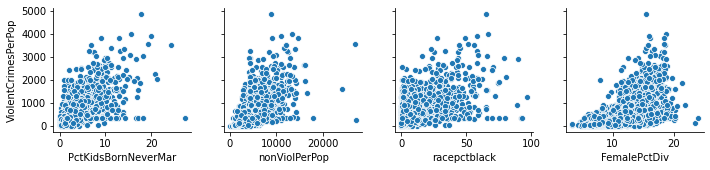

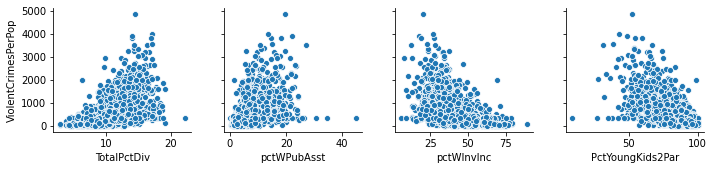

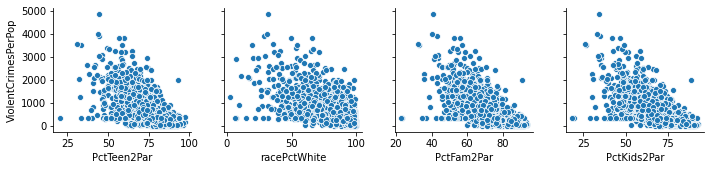

In [31]:
for i in range(0, len(top_features_viol_cols[:12]),4):
    sns.pairplot(data=top_features_viol_df, 
                 x_vars=top_features_viol_df.columns[i:i+4], 
                 y_vars=['ViolentCrimesPerPop'])

#### Outliers for strongly correlated features to violent crimes

Let's use the zscore to remove the outliers in some of our columns for our new **violent crimes** dataset.

In [32]:
PctKidsBornNeverMar_stats = top_features_viol_df.loc[:,['PctKidsBornNeverMar']]
PctKidsBornNeverMar_stats['zscore'] = stats.zscore(PctKidsBornNeverMar_stats['PctKidsBornNeverMar'])
PctKidsBornNeverMar_stats.describe().round(3)


,PctKidsBornNeverMar,zscore
count,2215.000,2215.000
mean,3.115,0.000
std,3.128,1.000
min,0.000,-0.996
25%,1.070,-0.654
50%,2.040,-0.344
75%,3.910,0.254
max,27.350,7.750


In [33]:
PctKidsBornNeverMar_stats.sort_values(by='zscore', ascending=False) 

,PctKidsBornNeverMar,zscore
1705,27.35,7.750141
720,24.19,6.739580
2068,21.31,5.818562
1470,20.80,5.655465
1213,20.00,5.399627
...,...,...
862,0.00,-0.996330
1479,0.00,-0.996330
1735,0.00,-0.996330
625,0.00,-0.996330


<AxesSubplot:xlabel='PctKidsBornNeverMar', ylabel='ViolentCrimesPerPop'>

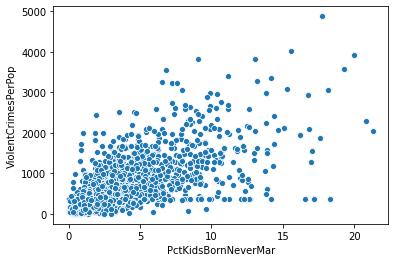

In [34]:
data.drop(data.index[[1705, 720]], inplace=True)
sns.scatterplot(data=data, x='PctKidsBornNeverMar', y='ViolentCrimesPerPop')


In [35]:
pctWPubAsst_stats = top_features_viol_df.loc[:, ["pctWPubAsst"]]
pctWPubAsst_stats["zscore"] = stats.zscore(pctWPubAsst_stats["pctWPubAsst"])
pctWPubAsst_stats.describe()


,pctWPubAsst,zscore
count,2215.000000,2.215000e+03
mean,6.801445,-3.889540e-17
std,4.700335,1.000226e+00
min,0.180000,-1.409036e+00
25%,3.270000,-7.514873e-01
50%,5.610000,-2.535381e-01
75%,9.105000,4.901939e-01
max,44.820000,8.090305e+00


In [36]:
pctWPubAsst_stats[(pctWPubAsst_stats["zscore"] > 5) | (pctWPubAsst_stats["zscore"] < -5)]

,pctWPubAsst,zscore
920,30.57,5.057921
1705,44.82,8.090305
1730,34.60,5.915500


<AxesSubplot:xlabel='pctWPubAsst', ylabel='ViolentCrimesPerPop'>

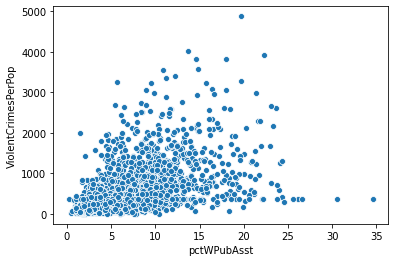

In [37]:
data.drop(data.index[[1705, 920, 1730]], inplace=True)
sns.scatterplot(data = data, x="pctWPubAsst", y="ViolentCrimesPerPop")

In [38]:
pctTeen2Par_stats = data.loc[:, ["PctTeen2Par"]]
pctTeen2Par_stats["zscore"] = stats.zscore(data["PctTeen2Par"])
pctTeen2Par_stats.describe().round(3)
# As we can see form the results below, all the data points in this column fall between 2 and -4. I'm comfortable enough with this to perform no transformation on any suspected outliers here.

,PctTeen2Par,zscore
count,2210.000,2210.000
mean,75.565,0.000
std,10.268,1.000
min,30.640,-4.376
25%,70.200,-0.523
50%,76.925,0.133
75%,82.773,0.702
max,97.340,2.121


*******************

Outlier assessment of our strongly correlated features that may impact our **non violent** crime rates. 

In [39]:
top_features_nonviol_cols = pd.DataFrame(top_features_nonviol).transpose().columns.tolist()
top_features_nonviol_cols.append('nonViolPerPop')
top_features_nonviol_df = data.loc[:, [i for i in top_features_nonviol_cols]]
top_features_nonviol_df.head(3)

,ViolentCrimesPerPop,TotalPctDiv,FemalePctDiv,MalePctDivorce,PctKidsBornNeverMar,PctPopUnderPov,PctYoungKids2Par,PctTeen2Par,PctFam2Par,PctKids2Par,nonViolPerPop
0,41.02,4.47,5.22,3.67,0.36,1.96,95.78,95.81,91.43,90.17,1394.59
1,127.56,5.42,6.45,4.23,0.24,3.98,96.82,86.46,86.91,85.33,1955.95
2,218.59,12.55,14.76,10.10,0.88,4.75,92.37,75.72,78.54,78.85,6167.51


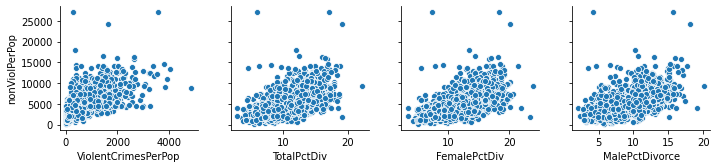

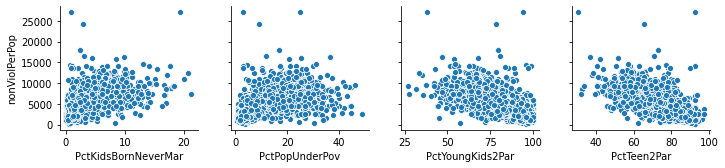

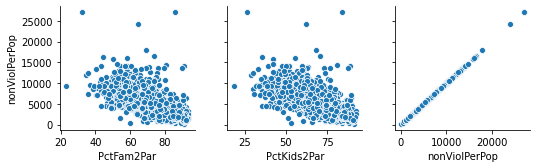

In [40]:
for i in range(0, len(top_features_nonviol_cols[:12]), 4):
    sns.pairplot(data=top_features_nonviol_df,
                 x_vars=top_features_nonviol_df.columns[i:i+4],
                 y_vars='nonViolPerPop')

In [41]:
TotalPctDiv_stats = data.loc[:, ["TotalPctDiv"]]
TotalPctDiv_stats["zscore"] = stats.zscore(data["TotalPctDiv"])
TotalPctDiv_stats.describe().round(3)

,TotalPctDiv,zscore
count,2210.000,2210.000
mean,10.802,0.000
std,2.994,1.000
min,2.830,-2.663
25%,8.570,-0.745
50%,10.880,0.026
75%,12.970,0.724
max,22.230,3.818


<AxesSubplot:xlabel='TotalPctDiv'>

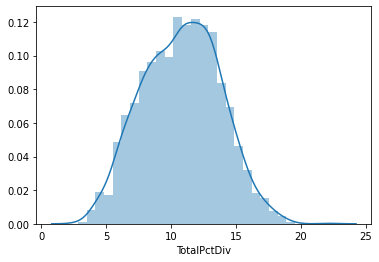

In [42]:
# Inspect distribution 
sns.distplot(data["TotalPctDiv"])
# Data in this column follows a normal distribution and the min and max zscore values do not warrant action on any outliers.

In [43]:
PctFam2Par_stats = data.loc[:, ["PctFam2Par"]]
PctFam2Par_stats["zscore"] = stats.zscore(data["PctFam2Par"])
PctFam2Par_stats.describe().round(3)

,PctFam2Par,zscore
count,2210.000,2210.000
mean,74.108,-0.000
std,10.440,1.000
min,22.970,-4.899
25%,67.945,-0.590
50%,75.050,0.090
75%,81.938,0.750
max,93.600,1.867


In [44]:

PctFam2Par_stats[PctFam2Par_stats["zscore"] < -4]
# I'm less concerned with records either greater than 5 STD from the mean or less than -5 STD from the mean. I will have no action for these records.

,PctFam2Par,zscore
1004,32.24,-4.011102
1730,22.97,-4.899200


In [45]:
TotalPctDiv_stats = data.loc[:, ["TotalPctDiv"]]
TotalPctDiv_stats["zscore"] = stats.zscore(data["TotalPctDiv"])
TotalPctDiv_stats.describe().round(3)
# Min and Max values fall between -2 and 4. I am not concerned with these scores and will keep the outliers in the dataset. 

,TotalPctDiv,zscore
count,2210.000,2210.000
mean,10.802,0.000
std,2.994,1.000
min,2.830,-2.663
25%,8.570,-0.745
50%,10.880,0.026
75%,12.970,0.724
max,22.230,3.818


### Feature Engineering

We will perform some feature engineering to transform our selected variables into a suitable state for analysis. This will predominantly be in the form of log transformation or feature scaling.

#### Log Transformation

Here we will inspect our predictor variables **violent crime rate per 100k pop** and **no violent crime rate per 100k pop** to see if the data is normally distributed.

***Non Violent crime distribution assessment***

<AxesSubplot:xlabel='nonViolPerPop'>

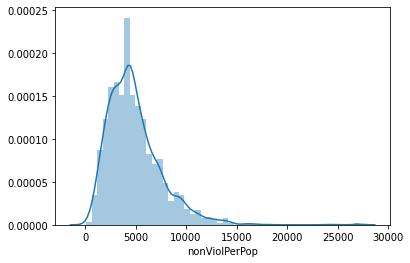

In [46]:
sns.distplot(data["nonViolPerPop"])

In [47]:
print(f"Non Violent skewness: {data.nonViolPerPop.skew()}" )

Non Violent skewness: 1.6456172033177028


As the plot indicates, our 'Non Violent Per Population' rate deviates from the normal distribution and has a slightly longer tail to the right. Therefore it has a positive skew. To verify this observation, our skewness level is 1.65. Since this is greater than 1, we can consider our 'nonViolPerPop' target variable to have a high level of skewness.

We'll now transfrom this data so it looks more normally distributed.

<AxesSubplot:xlabel='nonViolPerPop'>

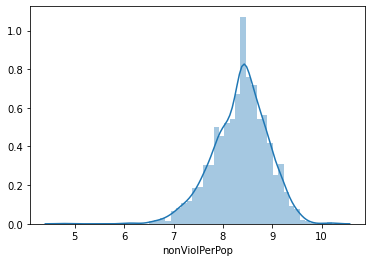

In [48]:
nV_log_transformed = np.log(data.nonViolPerPop)
sns.distplot(nV_log_transformed)

In [49]:
print(f"New skewness level for nonViolPerPop: {nV_log_transformed.skew()}") 

New skewness level for nonViolPerPop: -0.4861114457877774


As we can see, the log method transformed the 'nonViolPerPop' distribution into a more symmetrical bell curve and the skewness level is now 0.48, which is within the "fairly symmetrical" range.

***Violent crime distribution assessment***

<AxesSubplot:xlabel='ViolentCrimesPerPop'>

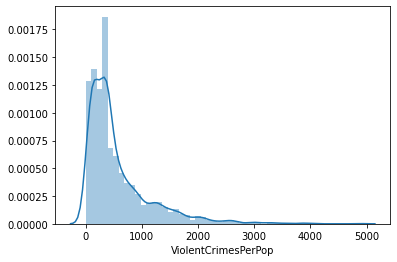

In [50]:
sns.distplot(data.ViolentCrimesPerPop)

Our distribution plot for the "ViolentCrimesPerPop" distribution appears to be even more positively skewed.  

In [51]:
print(f"Violent crimes per population skewness level: {data.ViolentCrimesPerPop.skew()}")

Violent crimes per population skewness level: 2.2273634361613364


c:\Users\User\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='ViolentCrimesPerPop'>

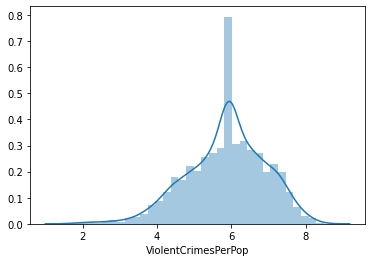

In [52]:
V_log_transformed = np.log(data["ViolentCrimesPerPop"])
is_finite = V_log_transformed[np.isfinite(V_log_transformed)]
# the np.isfinite() function will give you a boolean array the same size as the input array that is True wherever the finitie, i.e. non-Nan and non-inf.
sns.distplot(is_finite)

In [53]:
print(f"New skewness level for Violent Crimes Per Pop: {is_finite.skew()}")

New skewness level for Violent Crimes Per Pop: -0.42632566917161496


As we can see, the log method transformed the 'ViolentCrimesPerPop' distribution into a more symmetrical bell curve and the skewness level is now 0.43, which is within the "fairly symmetrical" range.


#### Feature Scaling

We will now perform feature scaling on the features selected in our variable selection process and our two predictor variables. We will use the *StandardScaler()* function in order to standardize our data. 

In [74]:
top_features_viol_cols
top_features_nonviol_cols
selected_data = data.loc[:, [i for i in top_features_viol_cols]]
print(len(selected_data.columns))
print(selected_data.columns.unique())

13
Index(['PctKidsBornNeverMar', 'nonViolPerPop', 'racepctblack', 'FemalePctDiv',
       'TotalPctDiv', 'pctWPubAsst', 'pctWInvInc', 'PctYoungKids2Par',
       'PctTeen2Par', 'racePctWhite', 'PctFam2Par', 'PctKids2Par',
       'ViolentCrimesPerPop'],
      dtype='object')


In [77]:
curr_list = selected_data.columns.unique().tolist()

for col in top_features_nonviol_cols:
    if col not in curr_list:
        curr_list.append(col)


In [78]:
curr_list

['PctKidsBornNeverMar',
 'nonViolPerPop',
 'racepctblack',
 'FemalePctDiv',
 'TotalPctDiv',
 'pctWPubAsst',
 'pctWInvInc',
 'PctYoungKids2Par',
 'PctTeen2Par',
 'racePctWhite',
 'PctFam2Par',
 'PctKids2Par',
 'ViolentCrimesPerPop',
 'MalePctDivorce',
 'PctPopUnderPov']

In [79]:
selected_data = data.loc[:,[i for i in curr_list]]
print(len(selected_data.columns))

15


In [80]:
selected_data.isnull().sum()

PctKidsBornNeverMar    0
nonViolPerPop          0
racepctblack           0
FemalePctDiv           0
TotalPctDiv            0
pctWPubAsst            0
pctWInvInc             0
PctYoungKids2Par       0
PctTeen2Par            0
racePctWhite           0
PctFam2Par             0
PctKids2Par            0
ViolentCrimesPerPop    0
MalePctDivorce         0
PctPopUnderPov         0
dtype: int64

In [81]:
selected_data.head(5)

,PctKidsBornNeverMar,nonViolPerPop,racepctblack,FemalePctDiv,TotalPctDiv,pctWPubAsst,pctWInvInc,PctYoungKids2Par,PctTeen2Par,racePctWhite,PctFam2Par,PctKids2Par,ViolentCrimesPerPop,MalePctDivorce,PctPopUnderPov
0,0.36,1394.59,1.37,5.22,4.47,1.03,70.20,95.78,95.81,91.78,91.43,90.17,41.02,3.67,1.96
1,0.24,1955.95,0.80,6.45,5.42,2.75,64.11,96.82,86.46,95.57,86.91,85.33,127.56,4.23,3.98
2,0.88,6167.51,0.74,14.76,12.55,2.94,55.73,92.37,75.72,94.33,78.54,78.85,218.59,10.10,4.75
3,3.84,4425.45,1.70,14.47,12.91,11.71,38.95,65.38,67.43,97.35,64.02,62.36,306.64,10.98,17.23
4,4.70,9988.79,0.53,11.64,9.73,11.21,42.82,66.51,79.17,89.16,58.59,55.20,374.06,7.51,29.99


In [83]:
import sys
data_standardized = StandardScaler().fit_transform(selected_data)
np.set_printoptions(precision=6, threshold=5)
data_standardized

array([[-0.895362, -1.3041  , -0.560702, ..., -0.900046, -1.948084,
        -1.128109],
       [-0.934649, -1.094096, -0.601089, ..., -0.751845, -1.747856,
        -0.891343],
       [-0.725122,  0.48144 , -0.60534 , ..., -0.595954,  0.35096 ,
        -0.80109 ],
       ...,
       [-0.489404, -0.084686, -0.620928, ..., -0.364354,  0.275875,
        -0.471726],
       [-0.243865,  0.172196, -0.418993, ...,  0.213346,  0.440347,
         2.196003],
       [ 0.574599,  1.480653, -0.48843 , ...,  0.60332 ,  2.378266,
         0.810565]])

### Hypothesis Testing